# Chunking Files with LangChain

There are 2 relevant types of chunking in LangChain.

1. **RecursiceCharacterTextSplitter**
    - Splitting a text into specific chunks based on the given pattern.

2. **Semantic Chunking**
    - Splitting a text into specific chunks based on the similiarity of the sentences.

In [61]:
import os
import pathlib
from pathlib import Path
from dotenv import load_dotenv, find_dotenv
from langchain_community.document_loaders import PyPDFLoader

load_dotenv(find_dotenv())

DATA_PATH = os.getenv("DATA_PATH")

In [62]:
def get_path(name: str) -> pathlib.WindowsPath:
    """ Create a path object for a file in the data directory

    Args:
        name (str): File name or directory name to search for

    Returns:
        pathlib.WindowsPath: Path object for the file or directory
    """
    return next(Path(DATA_PATH).rglob(name))

In [63]:
file_name = "ark_021_-_geschaeftsordnung_des_beirats.pdf"
path = get_path(file_name)

docs = PyPDFLoader(path).load()
len(docs)

3

## RecursiveCharacterTextSplitter

In [64]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [65]:
chunk_size = 1000
chunk_overlap = 300
separators = ["\n{2,}", "(?<=[.?!])\n", "(?<![zZbBwWfFsSrR\d])[.]|[!]|[?]"]

In [66]:
splitter = RecursiveCharacterTextSplitter(
    separators=separators,
    is_separator_regex=True,
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    strip_whitespace=True
)

In [67]:
chunks = splitter.split_documents(docs)
len(chunks)

7

## Semantic Chunking

Taken from Greg Kamradt's notebook: [5_Levels_Of_Text_Splitting](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb)

### With LangChain

In [68]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai import OpenAIEmbeddings

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [69]:
splitter = SemanticChunker(
    embeddings=OpenAIEmbeddings(api_key=OPENAI_API_KEY),
)

In [70]:
chunks = splitter.split_documents(docs)
len(chunks)

6

### Custom Semantic Chunking

In [71]:
import nltk
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.metrics.pairwise import cosine_similarity
from langchain_openai import OpenAIEmbeddings

#### 1. Loading the Data

In [86]:
doc = "\n".join(doc.page_content for doc in docs)

#### 2. Splitting the Data

##### 2.1 Regex

In [87]:
regex_pattern = r"(?<=(?<![aBfgmorsSuVz\d])[.])\s+|[!]\s+|[?]\s+"
single_sentences_re = re.split(regex_pattern, doc)
len(single_sentences_re)

27

##### 2.2 NLTK

In [88]:
single_sentences_nltk = nltk.sent_tokenize(doc, language='german')
len(single_sentences_nltk)

30

##### Combine Sentences

In [89]:
sentences_dict_re = [{'sentence': x, 'index' : i} for i, x in enumerate(single_sentences_re)]
sentences_dict_nltk = [{'sentence': x, 'index' : i} for i, x in enumerate(single_sentences_nltk)]

In [90]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences_dict_re = combine_sentences(sentences_dict_re)
sentences_dict_nltk = combine_sentences(sentences_dict_nltk)

#### 3. Embedding

In [91]:
openai_embedding = OpenAIEmbeddings(
    api_key=OPENAI_API_KEY,
    model="text-embedding-ada-002"
)

In [92]:
openai_embeddings_re = openai_embedding.embed_documents([x['combined_sentence'] for x in sentences_dict_re])
openai_embeddings_nltk = openai_embedding.embed_documents([x['combined_sentence'] for x in sentences_dict_nltk])

In [93]:
len(openai_embeddings_re), len(openai_embeddings_re[0]), len(openai_embeddings_nltk), len(openai_embeddings_nltk[0])

(27, 1536, 30, 1536)

In [94]:
for i, sentence_re in enumerate(sentences_dict_re):
    sentence_re['openai_embedding'] = openai_embeddings_re[i]

for i, sentence_nltk in enumerate(sentences_dict_nltk):
    sentence_nltk['openai_embedding'] = openai_embeddings_nltk[i]

#### 4. Compute Similarity

In [95]:
def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['openai_embedding']
        embedding_next = sentences[i + 1]['openai_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]
        
        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

In [96]:
distances_re_openai, sentences_dict_re = calculate_cosine_distances(sentences_dict_re)
distances_nltk_openai, sentences_dict_nltk = calculate_cosine_distances(sentences_dict_nltk)

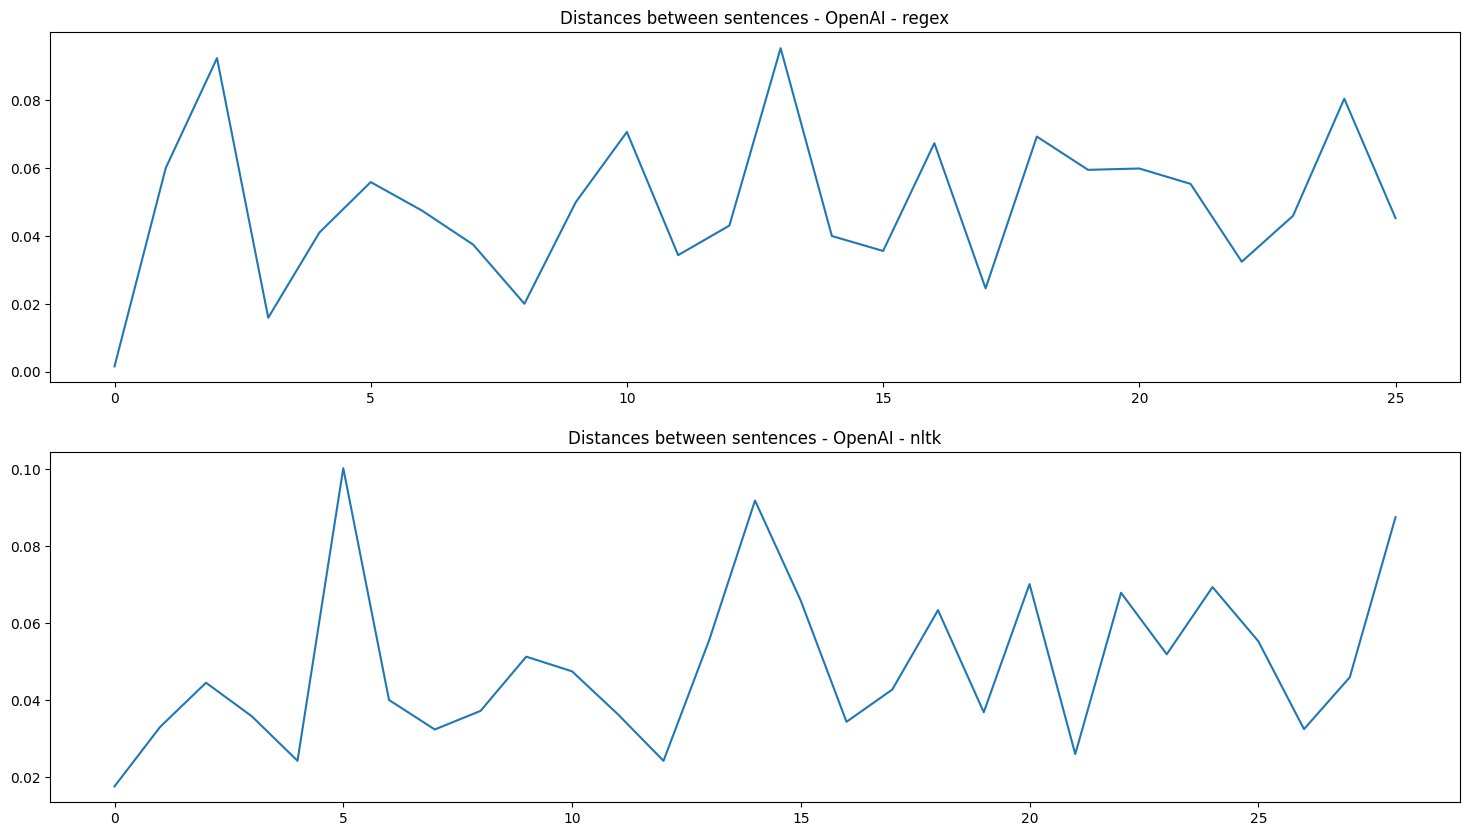

In [97]:
# plot 4 figures about the distances

plt.figure(figsize=(40, 10))

plt.subplot(2, 2, 1)
plt.plot(distances_re_openai)
plt.title("Distances between sentences - OpenAI - regex")

plt.subplot(2, 2, 3)
plt.plot(distances_nltk_openai)
plt.title("Distances between sentences - OpenAI - nltk")

plt.show()

#### 5. Create Chunks

In [98]:
def plot_distances_chunks(distances, model, splitter, threshold=95, plot=False):
    if plot:
        plt.plot(distances)

    if plot:
        y_upper_bound = .2
        plt.ylim(0, y_upper_bound)
        plt.xlim(0, len(distances))

    # We need to get the distance threshold that we'll consider an outlier
    # We'll use numpy .percentile() for this
    breakpoint_percentile_threshold = threshold
    breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
    if plot:
        plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

    # Then we'll see how many distances are actually above this one
    num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
    if plot:
        plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

    # Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
    indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

    # Start of the shading and text
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, breakpoint_index in enumerate(indices_above_thresh):
        start_index = 0 if i == 0 else indices_above_thresh[i - 1]
        end_index = breakpoint_index if i <= len(indices_above_thresh) - 1 else len(distances)

        if plot:
            plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
            plt.text(x=np.average([start_index, end_index]),
                y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                s=f"Chunk #{i}", horizontalalignment='center',
                rotation='vertical')

    # # Additional step to shade from the last breakpoint to the end of the dataset
    if indices_above_thresh and plot:
        last_breakpoint = indices_above_thresh[-1]
        if last_breakpoint < len(distances):
            plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
            plt.text(x=np.average([last_breakpoint, len(distances)]),
                y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                s=f"Chunk #{i+1}",
                rotation='vertical')

    if plot:
        plt.title(f"Chunks of text based on {model} embeddings and {splitter} splitting")
        plt.xlabel("Index of sentences (Sentence Position)")
        plt.ylabel("Cosine distance between sequential sentences")
        plt.show()

    return indices_above_thresh

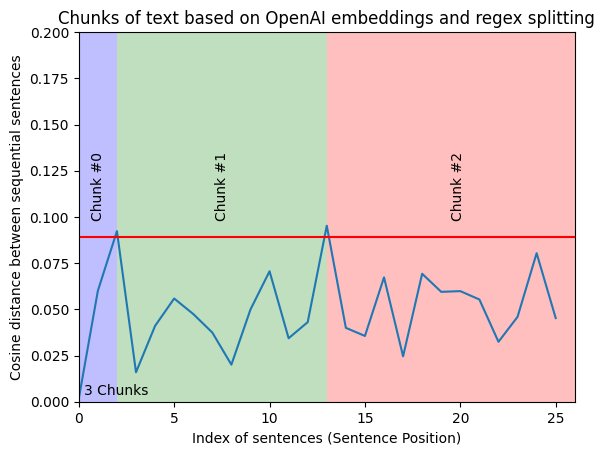

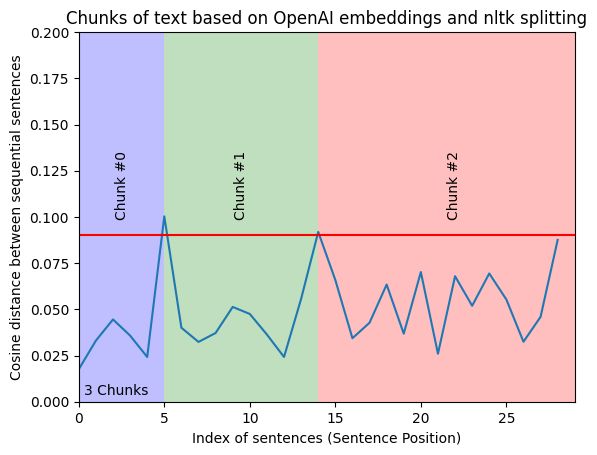

([2, 13], [5, 14])

In [99]:
threshold = 95
show_plot = True

plot_distances_chunks(distances_re_openai, "OpenAI", "regex", threshold, plot=show_plot),  plot_distances_chunks(distances_nltk_openai, "OpenAI", "nltk", threshold, plot=show_plot)

In [100]:
def create_chunks(sentences_dict, indices_above_thresh):
    # Initialize the start index
    start_index = 0

    # Create a list to hold the grouped sentences
    chunks = []

    # Iterate through the breakpoints to slice the sentences
    for index in indices_above_thresh:
        # The end index is the current breakpoint
        end_index = index

        # Slice the sentence_dicts from the current start index to the end index
        group = sentences_dict[start_index:end_index + 1]
        combined_text = ' '.join([d['sentence'] for d in group])
        chunks.append(combined_text)
        
        # Update the start index for the next group
        start_index = index + 1

    # The last group, if any sentences remain
    if start_index < len(sentences_dict):
        combined_text = ' '.join([d['sentence'] for d in sentences_dict[start_index:]])
        chunks.append(combined_text)

    return chunks

In [101]:
chunks_re_openai = create_chunks(sentences_dict_re, plot_distances_chunks(distances_re_openai, "OpenAI", "regex", threshold))
chunks_nltk_openai = create_chunks(sentences_dict_nltk, plot_distances_chunks(distances_nltk_openai, "OpenAI", "nltk", threshold))

In [ ]:
for i, chunk in enumerate(chunks_re_openai):
    print(f"Chunk #{i}")
    words = chunk.split()
    for i, word in enumerate(words):
        print(word, end=" ")
        if i%14 == 0 and i != 0:
            print("")
    print("\n")